In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy


/Users/ithallo/anaconda/envs/mlearning/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("./dataset/BTC-USD.csv", )
df.Date = pd.to_datetime(df.Date)
print df.head()

        Date         Open         High          Low        Close    Adj Close  \
0 2017-06-06  2870.500000  2880.949951  2626.560059  2691.510010  2691.510010   
1 2017-06-07  2691.510010  2808.409912  2623.610107  2798.780029  2798.780029   
2 2017-06-08  2798.780029  2852.070068  2786.070068  2811.429932  2811.429932   
3 2017-06-09  2811.429932  2914.189941  2807.360107  2900.250000  2900.250000   
4 2017-06-10  2900.250000  2977.860107  2867.250000  2973.449951  2973.449951   

      Volume  
0  340329903  
1  260898606  
2  189237110  
3  246869682  
4  241516660  


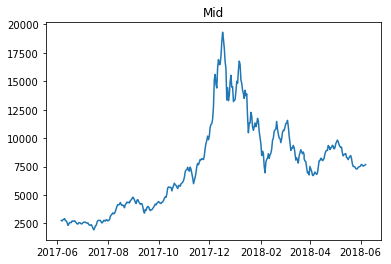

(365,)


In [3]:
mid = ((df.High + df.Low)/2.)
plt.plot(df.Date, mid)
plt.title("Mid")
plt.show()
print mid.shape

## Regressor

In [4]:
days = 7
span =30

# return the time series till the day before to the day after
def series_creator(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i + foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator(a, y, length=2, foresee_days=4)


(array([[1, 2],
       [2, 3]]), array([16, 17]))


In [41]:
X, y = series_creator(X=mid.values, y=df.High, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler()
scaler.fit(X)
X_std = scaler.transform(X)


(328, 30) (328,)


In [42]:
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)
print X_train_std.shape, X_test_std.shape
print y_train.shape, y_test.shape
generic_x = np.arange(len(y_test))

(219, 30) (109, 30)
(219,) (109,)


In [7]:
reg =  MLPRegressor(algorithm='adam', alpha=0.1, hidden_layer_sizes=(60), random_state=None,
                verbose=False, max_iter=10000, shuffle= False, tol=1e-10, early_stopping=False,
                   momentum=0.9)

In [8]:
def best_finder(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std, y_train)
        mf = ann.score(X_test_std, y_test)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

In [9]:
reg = best_finder(reg, 1)
print reg.score(X_test_std, y_test)

better one found: 0.7888785513989987 0
0.7888785513989987


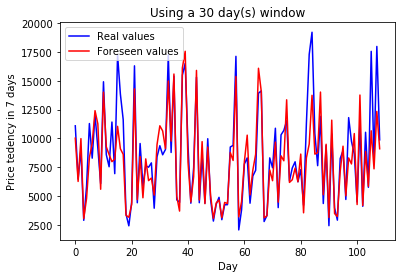

In [10]:
pred = reg.predict(X_test_std)

plt.plot(y_test, c='b', label="Real values")
plt.plot(pred, c='r', label="Foreseen values")
plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

## Looking the trends (in %)

In [11]:
# return the time series till the day before to the day after, but in % to the previous
def series_creator_percent(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(float(y[i + foresee_days-1])/y[i-1] - 1)
            #y_n.append(y[i-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
print series_creator_percent(a,y, length=1, foresee_days=1)

(array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]]), array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667]))


In [43]:
X2, y2 = series_creator_percent(X=mid.values, y=df.High, length=span, foresee_days=days) # because 1 is default
print X2.shape, y2.shape
scaler = MinMaxScaler()
scaler.fit(X2)
X_std2 = scaler.transform(X2)


(328, 30) (328,)


In [44]:
X_train_std2, X_test_std2, y_train2, y_test2 = train_test_split(X_std2, y2, test_size=0.33, random_state=42)
print X_train_std2.shape, X_test_std2.shape
print y_train2.shape, y_test2.shape

(219, 30) (109, 30)
(219,) (109,)


In [16]:
y_test_bin = np.where(1, y_test2>0, 0)

def bin_score(pred, y_bin):
    res = 0
    le = len(pred)
    pred_bin = np.where(1, pred>0, 0)
    for i in xrange(le):
        if y_bin[i]==pred_bin[i]:
            res +=1
    return float(res)/le


def best_finder_b(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std2, y_train2)
        pred = ann.predict(X_test_std2)
        mf = bin_score(pred, y_test_bin)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

### Seeing tendencies in the binariazation of the regressor

In [20]:
#reg.fit(X_train_std, y_train)
reg2 = best_finder_b(reg, 500, 0.2)
print reg2.score(X_test_std2, y_test2)
pred2 = reg2.predict(X_test_std2)
print "Accuracy for binarization", bin_score(pred2, y_test_bin)
pred_bin = np.where(1, pred2>0, 0)


better one found: 0.348623853211 0
better one found: 0.559633027523 1
better one found: 0.697247706422 3
better one found: 0.733944954128 19
better one found: 0.770642201835 39
better one found: 0.779816513761 153
0.08584178185779079
Accuracy for binarization 0.779816513761


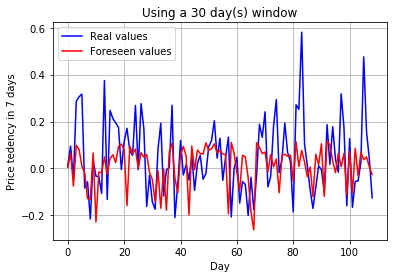

In [21]:
plt.plot(y_test2, c='b', label="Real values")
plt.plot(pred2, c='r', label="Foreseen values")
plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

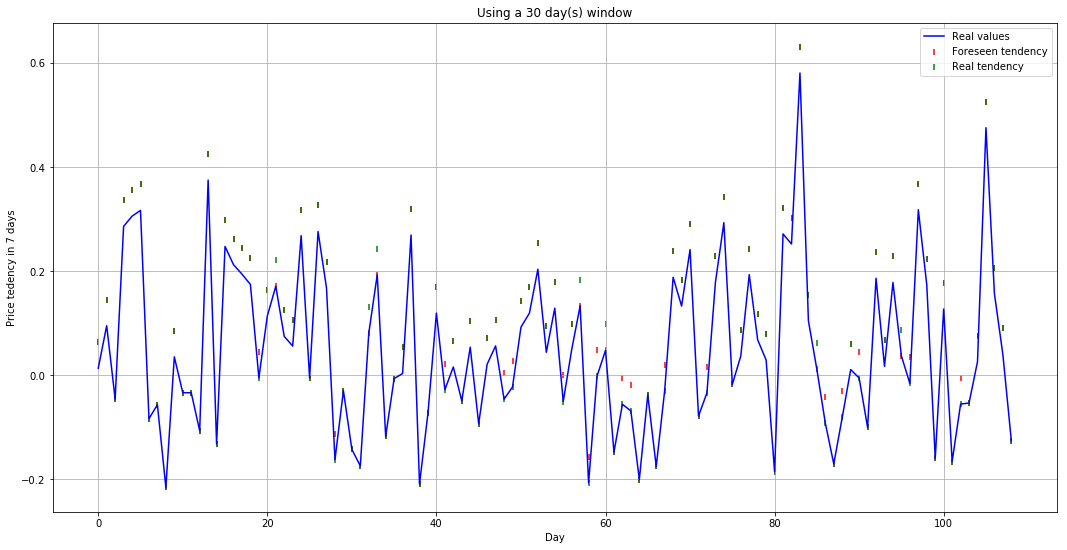

In [73]:

v = y_test2 + pred_bin/20.
v1 = y_test2 + y_test_bin/20.

plt.figure(figsize = (18,9))
plt.plot(generic_x, y_test2, c='b', label="Real values")

plt.scatter(generic_x, v, c="r", marker="|", label="Foreseen tendency")
plt.scatter(generic_x, v1, c='g', marker="|", label="Real tendency")

plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')

plt.show()

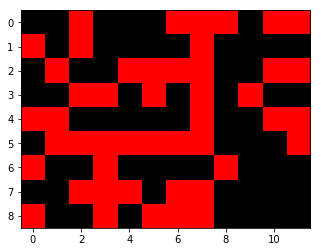

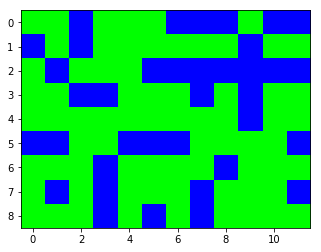

In [36]:
plt.imshow(y_test_bin[:-1].reshape(9, 12), cmap='flag')
plt.show()
plt.imshow(pred_bin[:-1].reshape(9, 12), cmap='brg')
plt.show()

In [45]:
y

(109,)